<a href="https://colab.research.google.com/github/maytlim/doh_data/blob/main/labresults.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
show_past_days = 5

In [2]:
import requests
import re
import pandas as pd
import datetime
import gdown
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24.3) or chardet (4.0.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:
try:
  import pdfx
except ModuleNotFoundError:
  !pip -q install pdfx
  import pdfx

In [4]:
#Code from https://gist.github.com/korakot/51a917e1f53891d53be223439b0f75c1
from google.colab import auth
auth.authenticate_user()  # must authenticate

'''list all ids of files directly under folder folder_id'''
def folder_list(folder_id):
  from googleapiclient.discovery import build
  gdrive = build('drive', 'v3', cache_discovery=False).files()
  #gdrive = build('drive', 'v3').files()
  res = gdrive.list(q="'%s' in parents" % folder_id).execute()
  return [f['id'] for f in res['files']]

'''download all files from a gdrive folder to current directory'''
def folder_download(folder_id):
  for fid in folder_list(folder_id):
    !gdown -q --id $fid

'''list all ids and filenames of files directly under folder folder_id'''
def folder_list_named(folder_id):
  from googleapiclient.discovery import build
  gdrive = build('drive', 'v3', cache_discovery=False).files()
  res = gdrive.list(q="'%s' in parents" % folder_id).execute()
  return [[f['id'], f['name']] for f in res['files']]

'''download specific file from a gdrive folder to current directory'''
def folder_download_specific(folder_id, search_term):
  for fid, fname in folder_list_named(folder_id):
    found = re.search(search_term, fname)
    if found:
      !gdown -q --id $fid

In [5]:
def folder_list_test(folder_id):
  from googleapiclient.discovery import build
  gdrive = build('drive', 'v3', cache_discovery=False).files()
  res = gdrive.list(q="'%s' in parents" % folder_id).execute()
  for f in res['files']:
    print(f)
  return [f['id'] for f in res['files']]

In [6]:
ddrop_readme = requests.get('http://bit.ly/DataDropPH').url
ddrop_readme = ddrop_readme.split('/')[-1].split('?')[0]
#print(ddrop_readme)
!rm *.pdf #remove existing pdf file before downloading 
folder_download(ddrop_readme)

In [7]:
readme_pdf = !ls *.pdf
readme_pdf = readme_pdf[0][1:-1]
readme_pdf
pdfx_tmp = pdfx.PDFx(readme_pdf)
ddlinks = pdfx_tmp.get_references_as_dict()

In [8]:
month_day = readme_pdf.split('_')
month = int(month_day[0][-2:])
day = int(month_day[1][:2])
month, day
year = 2022
print('DOH DataDrop Release:', year, month, day)

DOH DataDrop Release: 2022 1 3


In [9]:
search_term = 'Testing Aggregates'
downloaded = False
for ddlink in ddlinks['url']:
  if downloaded == False:
    if ddlink[:15] == 'https://bit.ly/' and ddlink[-3:] != 'ive':
      datadrop = requests.get(ddlink).url
      datadrop = datadrop.split('/')[-1].split('?')[0]
      #folder_download(datadrop)
      folder_download_specific(datadrop, search_term)
      print(search_term, '... downloaded')
      downloaded = True
  else:
    continue

Testing Aggregates ... downloaded


In [10]:
data_date = datetime.datetime(year, month, day)
#data_dir ='DOH COVID Data Drop_'  + data_date.strftime('%Y%m%d') + '/'

In [11]:
# testing aggregates - reporting labs
labs_filename = 'DOH COVID Data Drop_ ' + data_date.strftime('%Y%m%d') + ' - 07 Testing Aggregates.csv'
print('testing labs report:', labs_filename)

testing labs report: DOH COVID Data Drop_ 20220103 - 07 Testing Aggregates.csv


In [12]:
df_labs = pd.read_csv(labs_filename)
df_labs.keys()
date_labels = ['report_date']
for label in date_labels:
  df_labs[label] = pd.to_datetime(df_labs[label])

In [13]:
df_labs['daily_positivity'] = df_labs['daily_output_positive_individuals']/df_labs['daily_output_unique_individuals']

In [14]:
#df_labs.keys()

In [15]:
def show_hospital_details(df, hosp_name, by='daily_output_positive_individuals', min_threshold=15, show_num=5):
  filter = (df[by] > min_threshold) & (df_labs['facility_name'] == hosp_name)
  show_columns = ['report_date','daily_output_unique_individuals',
                  'daily_output_positive_individuals', 'daily_positivity','facility_name']
  return df[filter][show_columns].tail(show_num) 

In [16]:
def show_labs_list(df, by='daily_positivity', report_date='2021-12-27', cutoff_positivity=0.08, cutoff_count=100):
  filter = (df[by] > cutoff_positivity) & \
    (df['report_date'] == report_date) & \
    (df['daily_output_unique_individuals'] > cutoff_count)
  show_columns = ['report_date', 'daily_output_unique_individuals', 
                  'daily_output_positive_individuals', 'facility_name']
  return df[filter][show_columns]

In [17]:
for t in range(show_past_days):
  show_date = data_date - datetime.timedelta(days=t)
  rpt_date = show_date.strftime('%Y-%m-%d')
  df = show_labs_list(df_labs, by='daily_positivity', report_date=rpt_date, 
               cutoff_positivity=0.08, cutoff_count=100)
  df.sort_values(by='daily_output_positive_individuals', inplace=True, ascending=False)
  with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 0,
                       'display.max_colwidth', -1,
                       ):
    display(df)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,facility_name


,report_date,daily_output_unique_individuals,daily_output_positive_individuals,facility_name
107968,2022-01-02,1689,610,The Lord's Grace Medical and Industrial Clinic
32845,2022-01-02,1901,467,Detoxicare Molecular Diagnostics Laboratory
881,2022-01-02,629,264,AL Molecular Diagnostic Laboratory
23722,2022-01-02,567,234,Chinese General Hospital
59929,2022-01-02,433,191,"Marilao Medical and Diagnosc Clinic, Inc. - Pasay City"
82515,2022-01-02,414,178,Philippine Red Cross - Port Area
38031,2022-01-02,558,169,El Roi Molecular Diagnostic Laboratory
47504,2022-01-02,301,164,JT Cenica Medical Health System
84535,2022-01-02,434,162,Philippine Red Cross Logistics & Multipurpose Center
56385,2022-01-02,487,156,Manila Doctors Hospital


,report_date,daily_output_unique_individuals,daily_output_positive_individuals,facility_name
32844,2022-01-01,1973,366,Detoxicare Molecular Diagnostics Laboratory
107967,2022-01-01,950,320,The Lord's Grace Medical and Industrial Clinic
9814,2022-01-01,552,252,"Be Safe MD, Inc."
82514,2022-01-01,423,241,Philippine Red Cross - Port Area
23721,2022-01-01,653,227,Chinese General Hospital
38030,2022-01-01,503,187,El Roi Molecular Diagnostic Laboratory
38461,2022-01-01,377,129,"Ermita Molecular Diagnostic Laboratory, Inc."
47503,2022-01-01,372,126,JT Cenica Medical Health System
55568,2022-01-01,232,98,Makati Medical Center (MMC)
78060,2022-01-01,882,94,Philippine Children's Medical Center


,report_date,daily_output_unique_individuals,daily_output_positive_individuals,facility_name
32843,2021-12-31,2400,458,Detoxicare Molecular Diagnostics Laboratory
107966,2021-12-31,961,304,The Lord's Grace Medical and Industrial Clinic
77455,2021-12-31,1389,247,Philippine Airport Diagnostic Laboratory
38460,2021-12-31,581,224,"Ermita Molecular Diagnostic Laboratory, Inc."
82513,2021-12-31,747,204,Philippine Red Cross - Port Area
23720,2021-12-31,423,200,Chinese General Hospital
66440,2021-12-31,423,178,New World Diagnostic Premium Medical Branch
9813,2021-12-31,461,170,"Be Safe MD, Inc."
38029,2021-12-31,614,132,El Roi Molecular Diagnostic Laboratory
84533,2021-12-31,415,125,Philippine Red Cross Logistics & Multipurpose Center


,report_date,daily_output_unique_individuals,daily_output_positive_individuals,facility_name
82512,2021-12-30,1307,409,Philippine Red Cross - Port Area
32842,2021-12-30,2058,235,Detoxicare Molecular Diagnostics Laboratory
107965,2021-12-30,836,226,The Lord's Grace Medical and Industrial Clinic
23719,2021-12-30,525,200,Chinese General Hospital
103701,2021-12-30,349,187,Sta. Ana Hospital - Closed System Molecular Laboratory (RT PCR)
77454,2021-12-30,1545,180,Philippine Airport Diagnostic Laboratory
66439,2021-12-30,476,154,New World Diagnostic Premium Medical Branch
79875,2021-12-30,966,143,Philippine Red Cross (PRC)
9812,2021-12-30,347,126,"Be Safe MD, Inc."
10168,2021-12-30,309,121,Best Diagnostic Corporation


In [18]:
show_hospital_details(df_labs, "Ospital ng Imus", 
                      by='daily_positivity', min_threshold=0.08, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
70565,2021-09-25,451.0,137.0,0.303769,Ospital ng Imus
70566,2021-09-26,437.0,52.0,0.118993,Ospital ng Imus
70568,2021-09-28,1363.0,124.0,0.090976,Ospital ng Imus
70569,2021-09-29,260.0,40.0,0.153846,Ospital ng Imus
70570,2021-09-30,697.0,85.0,0.121951,Ospital ng Imus
70572,2021-10-02,270.0,32.0,0.118519,Ospital ng Imus
70573,2021-10-03,211.0,24.0,0.113744,Ospital ng Imus
70628,2021-11-27,30.0,3.0,0.100000,Ospital ng Imus
70658,2021-12-27,1431.0,153.0,0.106918,Ospital ng Imus
70659,2021-12-28,1106.0,107.0,0.096745,Ospital ng Imus


In [19]:
show_hospital_details(df_labs, "Manila Doctors Hospital", 
                      by='daily_output_positive_individuals', min_threshold=50, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
56275,2021-09-14,565.0,70.0,0.123894,Manila Doctors Hospital
56277,2021-09-16,523.0,58.0,0.110899,Manila Doctors Hospital
56278,2021-09-17,486.0,65.0,0.133745,Manila Doctors Hospital
56281,2021-09-20,412.0,54.0,0.131068,Manila Doctors Hospital
56283,2021-09-22,446.0,53.0,0.118834,Manila Doctors Hospital
56285,2021-09-24,531.0,58.0,0.109228,Manila Doctors Hospital
56286,2021-09-25,447.0,61.0,0.136465,Manila Doctors Hospital
56382,2021-12-30,199.0,61.0,0.306533,Manila Doctors Hospital
56383,2021-12-31,214.0,62.0,0.289720,Manila Doctors Hospital
56385,2022-01-02,487.0,156.0,0.320329,Manila Doctors Hospital


In [20]:
show_hospital_details(df_labs, "Chinese General Hospital", 
                      by='daily_output_positive_individuals', min_threshold=100, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
23624,2021-09-26,942.0,167.0,0.177282,Chinese General Hospital
23626,2021-09-28,1077.0,176.0,0.163417,Chinese General Hospital
23627,2021-09-29,768.0,144.0,0.187500,Chinese General Hospital
23628,2021-09-30,828.0,128.0,0.154589,Chinese General Hospital
23630,2021-10-02,818.0,147.0,0.179707,Chinese General Hospital
23633,2021-10-05,697.0,106.0,0.152080,Chinese General Hospital
23719,2021-12-30,525.0,200.0,0.380952,Chinese General Hospital
23720,2021-12-31,423.0,200.0,0.472813,Chinese General Hospital
23721,2022-01-01,653.0,227.0,0.347626,Chinese General Hospital
23722,2022-01-02,567.0,234.0,0.412698,Chinese General Hospital


In [21]:
show_hospital_details(df_labs, "UP-PGH Molecular Laboratory", 
                      by='daily_output_positive_individuals', min_threshold=50, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
112985,2021-09-25,602.0,72.0,0.119601,UP-PGH Molecular Laboratory
112987,2021-09-27,513.0,64.0,0.124756,UP-PGH Molecular Laboratory
112988,2021-09-28,563.0,70.0,0.124334,UP-PGH Molecular Laboratory
112990,2021-09-30,546.0,54.0,0.098901,UP-PGH Molecular Laboratory
112994,2021-10-04,430.0,53.0,0.123256,UP-PGH Molecular Laboratory
112997,2021-10-07,329.0,54.0,0.164134,UP-PGH Molecular Laboratory
113081,2021-12-30,385.0,59.0,0.153247,UP-PGH Molecular Laboratory
113082,2021-12-31,495.0,90.0,0.181818,UP-PGH Molecular Laboratory
113083,2022-01-01,285.0,79.0,0.277193,UP-PGH Molecular Laboratory
113084,2022-01-02,136.0,53.0,0.389706,UP-PGH Molecular Laboratory


In [22]:
show_hospital_details(df_labs, "Philippine Children's Medical Center", 
                      by='daily_output_positive_individuals', min_threshold=50, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
77948,2021-09-11,366.0,63.0,0.172131,Philippine Children's Medical Center
77951,2021-09-14,560.0,57.0,0.101786,Philippine Children's Medical Center
77953,2021-09-16,616.0,52.0,0.084416,Philippine Children's Medical Center
77959,2021-09-22,583.0,70.0,0.120069,Philippine Children's Medical Center
77962,2021-09-25,856.0,70.0,0.081776,Philippine Children's Medical Center
77966,2021-09-29,287.0,56.0,0.195122,Philippine Children's Medical Center
78057,2021-12-29,1061.0,65.0,0.061263,Philippine Children's Medical Center
78059,2021-12-31,850.0,91.0,0.107059,Philippine Children's Medical Center
78060,2022-01-01,882.0,94.0,0.106576,Philippine Children's Medical Center
78061,2022-01-02,942.0,93.0,0.098726,Philippine Children's Medical Center


In [23]:
show_hospital_details(df_labs, "Best Diagnostic Corporation", 
                      by='daily_output_positive_individuals', min_threshold=30, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
10079,2021-10-02,117.0,32.0,0.273504,Best Diagnostic Corporation
10082,2021-10-05,125.0,41.0,0.328000,Best Diagnostic Corporation
10083,2021-10-06,163.0,48.0,0.294479,Best Diagnostic Corporation
10085,2021-10-08,155.0,31.0,0.200000,Best Diagnostic Corporation
10088,2021-10-11,73.0,33.0,0.452055,Best Diagnostic Corporation
10089,2021-10-12,126.0,31.0,0.246032,Best Diagnostic Corporation
10096,2021-10-19,171.0,35.0,0.204678,Best Diagnostic Corporation
10166,2021-12-28,180.0,38.0,0.211111,Best Diagnostic Corporation
10167,2021-12-29,212.0,93.0,0.438679,Best Diagnostic Corporation
10168,2021-12-30,309.0,121.0,0.391586,Best Diagnostic Corporation


In [24]:
show_hospital_details(df_labs, "Detoxicare Molecular Diagnostics Laboratory", 
                      by='daily_output_positive_individuals', min_threshold=300, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
32750,2021-09-29,3039.0,534.0,0.175716,Detoxicare Molecular Diagnostics Laboratory
32751,2021-09-30,3032.0,519.0,0.171174,Detoxicare Molecular Diagnostics Laboratory
32752,2021-10-01,3087.0,413.0,0.133787,Detoxicare Molecular Diagnostics Laboratory
32753,2021-10-02,3345.0,485.0,0.144993,Detoxicare Molecular Diagnostics Laboratory
32754,2021-10-03,2827.0,383.0,0.135479,Detoxicare Molecular Diagnostics Laboratory
32756,2021-10-05,3034.0,405.0,0.133487,Detoxicare Molecular Diagnostics Laboratory
32757,2021-10-06,3077.0,336.0,0.109197,Detoxicare Molecular Diagnostics Laboratory
32843,2021-12-31,2400.0,458.0,0.190833,Detoxicare Molecular Diagnostics Laboratory
32844,2022-01-01,1973.0,366.0,0.185504,Detoxicare Molecular Diagnostics Laboratory
32845,2022-01-02,1901.0,467.0,0.245660,Detoxicare Molecular Diagnostics Laboratory


In [25]:
show_hospital_details(df_labs, "Detoxicare Molecular Diagnostics Laboratory", 
                      by='daily_positivity', min_threshold=0.15, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
32744,2021-09-23,4012.0,748.0,0.186441,Detoxicare Molecular Diagnostics Laboratory
32745,2021-09-24,3290.0,628.0,0.190881,Detoxicare Molecular Diagnostics Laboratory
32746,2021-09-25,3012.0,536.0,0.177955,Detoxicare Molecular Diagnostics Laboratory
32747,2021-09-26,2935.0,543.0,0.185009,Detoxicare Molecular Diagnostics Laboratory
32749,2021-09-28,2930.0,554.0,0.189078,Detoxicare Molecular Diagnostics Laboratory
32750,2021-09-29,3039.0,534.0,0.175716,Detoxicare Molecular Diagnostics Laboratory
32751,2021-09-30,3032.0,519.0,0.171174,Detoxicare Molecular Diagnostics Laboratory
32843,2021-12-31,2400.0,458.0,0.190833,Detoxicare Molecular Diagnostics Laboratory
32844,2022-01-01,1973.0,366.0,0.185504,Detoxicare Molecular Diagnostics Laboratory
32845,2022-01-02,1901.0,467.0,0.245660,Detoxicare Molecular Diagnostics Laboratory


In [26]:
show_hospital_details(df_labs, "San Lazaro Hospital (SLH)", by='daily_output_positive_individuals', min_threshold=50, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
94872,2021-09-06,185.0,69.0,0.372973,San Lazaro Hospital (SLH)
94874,2021-09-08,190.0,64.0,0.336842,San Lazaro Hospital (SLH)
94875,2021-09-09,178.0,57.0,0.320225,San Lazaro Hospital (SLH)
94876,2021-09-10,152.0,64.0,0.421053,San Lazaro Hospital (SLH)
94878,2021-09-12,201.0,74.0,0.368159,San Lazaro Hospital (SLH)
94882,2021-09-16,217.0,67.0,0.308756,San Lazaro Hospital (SLH)
94883,2021-09-17,166.0,65.0,0.391566,San Lazaro Hospital (SLH)
94885,2021-09-19,175.0,55.0,0.314286,San Lazaro Hospital (SLH)
94897,2021-10-01,177.0,53.0,0.299435,San Lazaro Hospital (SLH)
94988,2021-12-31,120.0,73.0,0.608333,San Lazaro Hospital (SLH)


In [27]:
show_hospital_details(df_labs, "Sta. Ana Hospital - Closed System Molecular Laboratory (RT PCR)", 
                      by='daily_output_positive_individuals', min_threshold=100, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,daily_positivity,facility_name
103589,2021-09-09,546.0,133.0,0.243590,Sta. Ana Hospital - Closed System Molecular La...
103591,2021-09-11,454.0,105.0,0.231278,Sta. Ana Hospital - Closed System Molecular La...
103594,2021-09-14,641.0,138.0,0.215289,Sta. Ana Hospital - Closed System Molecular La...
103596,2021-09-16,640.0,114.0,0.178125,Sta. Ana Hospital - Closed System Molecular La...
103601,2021-09-21,729.0,122.0,0.167353,Sta. Ana Hospital - Closed System Molecular La...
103602,2021-09-22,459.0,109.0,0.237473,Sta. Ana Hospital - Closed System Molecular La...
103604,2021-09-24,549.0,107.0,0.194900,Sta. Ana Hospital - Closed System Molecular La...
103605,2021-09-25,544.0,109.0,0.200368,Sta. Ana Hospital - Closed System Molecular La...
103701,2021-12-30,349.0,187.0,0.535817,Sta. Ana Hospital - Closed System Molecular La...
103702,2021-12-31,234.0,105.0,0.448718,Sta. Ana Hospital - Closed System Molecular La...


In [28]:
def juxtapose_spreads(df, show_dates):
  n_dates = len(show_dates)
  filter = []
  xhigh = 0
  for i, show_date in enumerate(show_dates):
    filter.append(df['report_date'] == show_date)
    xhigh = max(df[filter[i]]['daily_output_positive_individuals'].max(), xhigh) 

  fig, axes = plt.subplots(ncols=n_dates, figsize=(n_dates*5 + 2, 5))

  for i in range(n_dates):
    axes[i].plot(df[filter[i]]['daily_positivity']*100, 
         df[filter[i]]['daily_output_positive_individuals'],
         'ro', alpha=0.33)
    axes[i].set_xlabel('positivity (%)')
    axes[i].set_ylabel('positive cases')
    axes[i].set_ylim(bottom=0, top=xhigh+5)
    axes[i].set_xlim(right=100) 
    axes[i].set_title(show_dates[i])

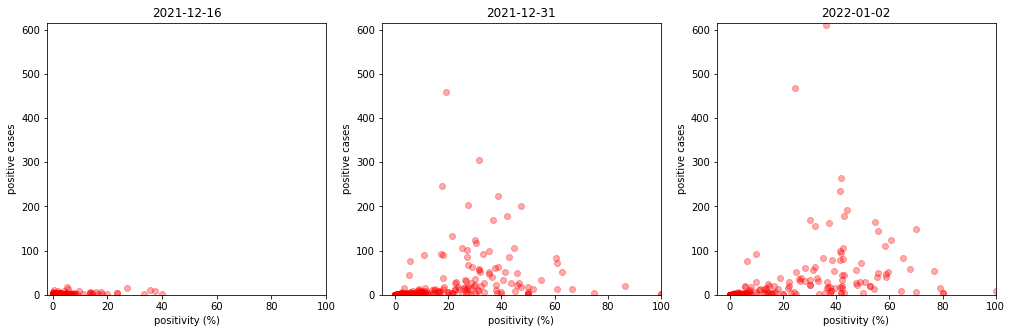

In [29]:
show_date = data_date - datetime.timedelta(days=1)
latest_date = show_date.strftime('%Y-%m-%d')
juxtapose_spreads(df_labs, ['2021-12-16', '2021-12-31', latest_date])

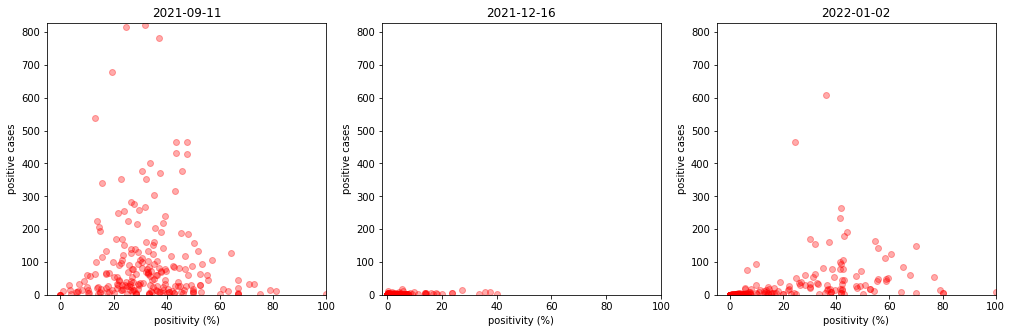

In [30]:
juxtapose_spreads(df_labs, ['2021-09-11', '2021-12-16', latest_date])